<a href="https://colab.research.google.com/github/rcpaffenroth/dac_raghu/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib widget

In [2]:
df = pd.read_parquet('data/lander_all_data.parquet')
#  Just the better runs, but all the x values
data = df.loc[('trained', slice(None)), (slice(None),('x','y', 'vx', 'vy'))]

In [3]:
data

idx                      0         1         2         3         4    \
parameter                  x         x         x         x         x   
run_idx experiment                                                     
trained 0          -0.001627 -0.003505 -0.005382 -0.007259 -0.009137   
        1          -0.005120 -0.005355 -0.005590 -0.005825 -0.006060   
        2          -0.000479 -0.003802 -0.007125 -0.010448 -0.013771   
        3          -0.005287 -0.007566 -0.009845 -0.012124 -0.014403   
        4          -0.005204 -0.011229 -0.017253 -0.023278 -0.029302   
...                      ...       ...       ...       ...       ...   
        1019        0.006561  0.022115  0.037669  0.053223  0.068777   
        1020        0.004974  0.015659  0.026343  0.037028  0.047713   
        1021       -0.007446 -0.000433  0.006580  0.013593  0.020606   
        1022        0.006551  0.020013  0.033475  0.046937  0.060399   
        1023       -0.004069  0.004273  0.012615  0.020956  0.029298   

idx                      5         6         7         8         9    ...  \
parameter                  x         x         x         x         x  ...   
run_idx experiment                                                    ...   
trained 0          -0.011014 -0.012892 -0.014769 -0.016647 -0.018524  ...   
        1          -0.006295 -0.006530 -0.006764 -0.006999 -0.007234  ...   
        2          -0.017094 -0.020417 -0.023740 -0.027063 -0.030386  ...   
        3          -0.016683 -0.018962 -0.021241 -0.023520 -0.025799  ...   
        4          -0.035326 -0.041172 -0.047017 -0.052863 -0.058708  ...   
...                      ...       ...       ...       ...       ...  ...   
        1019        0.084331  0.099885  0.115439  0.130994  0.146548  ...   
        1020        0.058397  0.069082  0.079766  0.090451  0.101136  ...   
        1021        0.027618  0.034631  0.041644  0.048657  0.055670  ...   
        1022        0.073861  0.087323  0.100785  0.114247  0.127709  ...   
        1023        0.037640  0.045982  0.054324  0.062665  0.071007  ...   

idx                      91        92        93        94        95   \
parameter                 vy        vy        vy        vy        vy   
run_idx experiment                                                     
trained 0          -0.636416 -0.638210 -0.640003 -0.641797 -0.643590   
        1          -0.906278 -0.918768 -0.931257 -0.943747 -0.956237   
        2          -0.279203 -0.271335 -0.263467 -0.255599 -0.247730   
        3          -0.860781 -0.868364 -0.875947 -0.883530 -0.891113   
        4          -0.911074 -0.910321 -0.909567 -0.908814 -0.908060   
...                      ...       ...       ...       ...       ...   
        1019       -0.173952 -0.171624 -0.169296 -0.166968 -0.164639   
        1020       -0.474361 -0.483990 -0.493620 -0.503249 -0.512879   
        1021       -0.539696 -0.547828 -0.555960 -0.564091 -0.572223   
        1022       -0.311161 -0.285919 -0.260677 -0.235435 -0.210193   
        1023       -0.328814 -0.331235 -0.333656 -0.336078 -0.338499   

idx                      96        97        98        99        100  
parameter                 vy        vy        vy        vy        vy  
run_idx experiment                                                    
trained 0          -0.645383 -0.647177 -0.648970 -0.650764 -0.652557  
        1          -0.968727 -0.981217 -0.993707 -1.006196 -1.018686  
        2          -0.239862 -0.231994 -0.224125 -0.216257 -0.208389  
        3          -0.898695 -0.906278 -0.913861 -0.921444 -0.929027  
        4          -0.921853 -0.935646 -0.949438 -0.963231 -0.977024  
...                      ...       ...       ...       ...       ...  
        1019       -0.162311 -0.159983 -0.157655 -0.155327 -0.152999  
        1020       -0.522508 -0.532138 -0.541767 -0.551397 -0.561026  
        1021       -0.580355 -0.588487 -0.596619 -0.604751 -0.612883  
        1022       -0.184951 -0.159708 -0.134466 -0

# Some basic plots

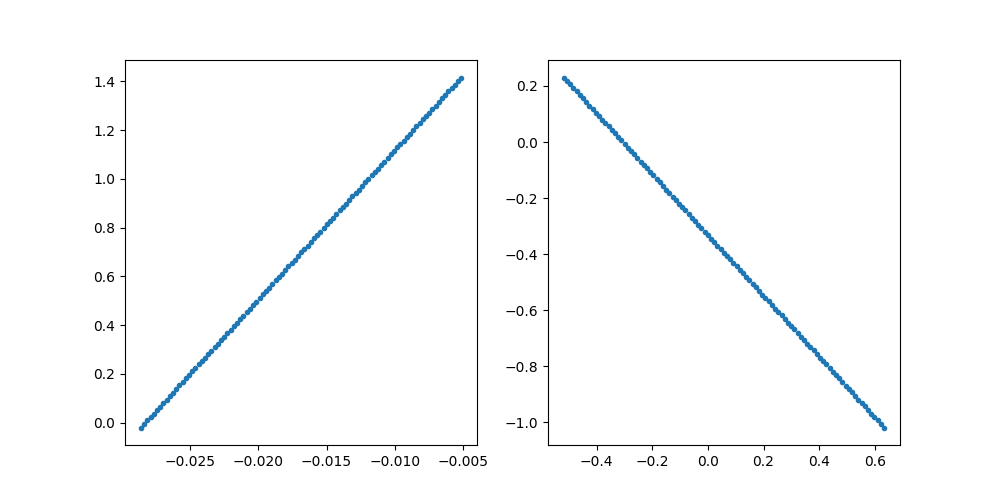

In [4]:
x = data.loc[:,(slice(None),'x')].values
y = data.loc[:,(slice(None),'y')].values
vx = data.loc[:,(slice(None),'vx')].values
vy = data.loc[:,(slice(None),'vy')].values


_,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(x[1,:],y[1,:], marker='.')
ax[1].scatter(vx[1,:],vy[1,:], marker='.')


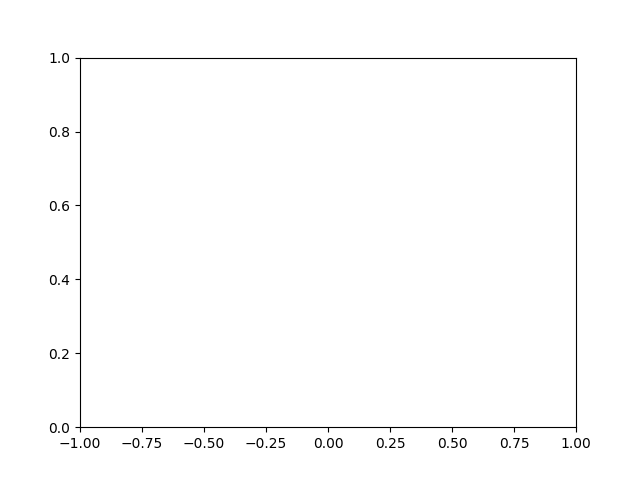

IndexError: index 0 is out of bounds for axis 1 with size 0

In [7]:
fig, ax = plt.subplots()

scat = ax.scatter(t[0], z[0], c="b", s=5, label=f'v0 = {v0} m/s')
line2 = ax.plot(t[0], z2[0], label=f'v0 = {v02} m/s')[0]
ax.set(xlim=[0, 3], ylim=[-4, 10], xlabel='Time [s]', ylabel='Z [m]')
ax.legend()


def update(frame):
    # for each frame, update the data stored on each artist.
    x_sub = x[:frame]
    y_sub = y[:frame]
    # update the scatter plot:
    data = np.stack([x_sub, y_sub]).T
    scat.set_offsets(data)
    # update the line plot:
    line2.set_xdata(t[:frame])
    line2.set_ydata(z2[:frame])
    return (scat, line2)


ani = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=30)
plt.show()

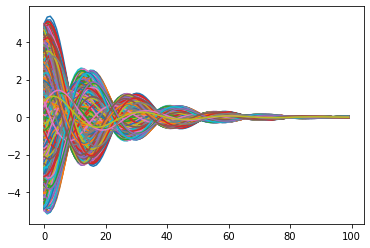

In [5]:
py.plot(data_2d.T);

# Auto-encoder

Based on https://www.kaggle.com/code/sinclairg/pytorch-lightning-tutorial-autoencoders

In [6]:
! pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 54.8 MB/s eta 0:00:00


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pytorch_lightning as pl

In [8]:
encoder = nn.Sequential(nn.Linear(100, 64), 
                        nn.ELU(), 
                        nn.Linear(64, 32), 
                        nn.ELU(), 
                        nn.Linear(32, 2))
decoder = nn.Sequential(nn.Linear(2, 32), 
                        nn.ELU(), 
                        nn.Linear(32, 64),
                        nn.ELU(), 
                        nn.Linear(64, 100))

In [9]:
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def training_step(self, batch, batch_idx):
        x = batch[0]
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        # Include extra logging here
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=0.001)
        return optimizer

In [10]:
ae = LitAutoEncoder(encoder, decoder)

In [11]:
dataset = torch.utils.data.TensorDataset(torch.Tensor(data_2d))
train_loader = torch.utils.data.DataLoader(dataset)

In [12]:
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model=ae, train_dataloaders=train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 8.6 K 
1 | decoder | Sequential | 8.7 K 
---------------------------------------
17.3 K    Trainable params
0         Non-trainable params
17.3 K    Total params
0.069     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [13]:
X =  torch.Tensor(data_2d)
H = encoder(X).detach()
X_hat = decoder(H).detach()

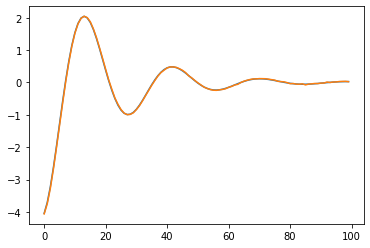

In [14]:
py.plot(X[0,:])
py.plot(X_hat[0,:])

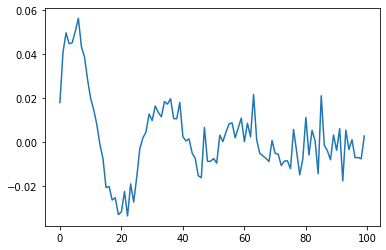

In [15]:
py.plot(X[0,:]-X_hat[0,:])

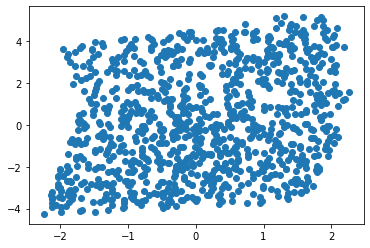

In [16]:
py.scatter(H[:,0], H[:,1])

tensor([-0.9209,  3.2718], grad_fn=<AddBackward0>)


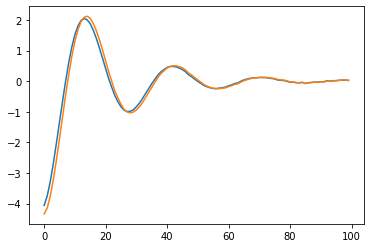

In [17]:
h = encoder(X[0,:])
print(h)
x_hat = decoder(h).detach()
py.plot(x_hat)

x_hat = decoder(h+torch.tensor([0.5, 0.5])).detach()
py.plot(x_hat)

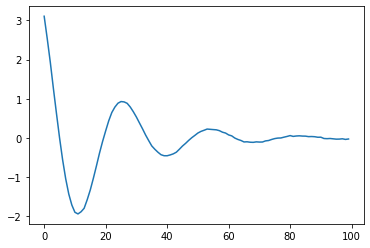

In [18]:
# h = torch.Tensor([2.8186, -2.0229])
h = torch.Tensor([2, -2])
x_hat = decoder(h).detach()
py.plot(x_hat)